In [2]:
import hyperopt
import numpy as np
from hyperopt import fmin, tpe, hp
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import keras

2023-09-08 11:24:33.537321: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 11:24:33.586858: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 11:24:33.587420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 11:24:34.719473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Загрузка и предобработка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_train = x_train.astype(np.float32)
x_train = np.reshape(x_train, [60000,784])
x_test = x_test.astype(np.float32)
x_test = np.reshape(x_test, [10000,784])
y_train = y_train.astype(np.int64)
y_train = y_train.astype(np.int64)

In [15]:
def objective(params):
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(params['units'], activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    
    return -val_accuracy  # Минимизация, так как Hyperopt ищет минимум функции

In [16]:
space = {
    'units': hp.choice('units', [32, 64, 128]),  # Количество нейронов в слое
    'learning_rate': hp.loguniform('learning_rate', -5, -1)  # Логарифмический выбор скорости обучения
}

In [17]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)  # Количество экспериментов
# на 7 эпохе достигла минимума и не менялась

100%|██████████| 10/10 [08:00<00:00, 48.04s/trial, best loss: -0.9587000012397766]


In [18]:
from scikeras.wrappers import KerasClassifier

x_train = x_train.astype(np.float32)
x_train = np.reshape(x_train, [60000,784])
x_test = x_test.astype(np.float32)
x_test = np.reshape(x_test, [10000,784])
y_train = y_train.astype(np.int64)
y_train = y_train.astype(np.int64)


def get_model(hidden_layer_dim, meta):
    # note that meta is a special argument that will be
    # handed a dict containing input metadata
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_features_in_, input_shape=X_shape_[1:]))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dense(hidden_layer_dim))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dense(n_classes_))
    model.add(keras.layers.Activation("softmax"))
    return model

clf = KerasClassifier(
    get_model,
    loss="sparse_categorical_crossentropy",
    hidden_layer_dim=100,
)

clf.fit(x_train, y_train)
y_proba = clf.predict_proba(x_train)


1875/1875 [==============================] - 5s 3ms/step


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', clf),
])

pipe.fit(x_train, y_train)
y_proba = pipe.predict_proba(x_test)

313/313 [==============================] - 1s 3ms/step


In [25]:
from sklearn.model_selection import GridSearchCV


params = {
    "hidden_layer_dim": [50, 100, 200],
    "loss": ["sparse_categorical_crossentropy"],
    "optimizer": ["adam", "sgd"],
    "optimizer__learning_rate": [0.0001, 0.001, 0.1],
}
gs = GridSearchCV(clf, params, refit=False, cv=3, scoring='accuracy')

gs.fit(x_train, y_train)
print(gs.best_score_, gs.best_params_)

625/625 [==============================] - 2s 3ms/step
0.9620000000000001 {'hidden_layer_dim': 50, 'loss': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'optimizer__learning_rate': 0.001}


In [20]:
from tensorflow.keras import layers, models, optimizers, losses
model_optimum = keras.models.Sequential()
model_optimum.add(keras.layers.Dense(50, input_shape=x_train.shape[1:]))
model_optimum.add(keras.layers.Activation("relu"))
model_optimum.add(keras.layers.Dense(50))
model_optimum.add(keras.layers.Activation("relu"))
model_optimum.add(keras.layers.Dense(10))
model_optimum.add(keras.layers.Activation("softmax"))

model_optimum.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_optimum.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2942 - accuracy: 0.9149
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1364 - accuracy: 0.9588
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1018 - accuracy: 0.9686
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0788 - accuracy: 0.9756
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0674 - accuracy: 0.9787
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0555 - accuracy: 0.9822
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0489 - accuracy: 0.9840
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0421 - accuracy: 0.9861
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0382 - accuracy: 0.9871
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.033

In [36]:
test_loss, test_acc = model_optimum.evaluate(x_test, y_test)
print(f"Accuracy on the test set: {test_acc * 100:.2f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0976 - accuracy: 0.9733
Accuracy on the test set: 97.33%


In [37]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "hidden_layer_dim": [50, 100, 200],
    "loss": ["sparse_categorical_crossentropy"],
    "optimizer": ["adam", "sgd"],
    "optimizer__learning_rate": [0.0001, 0.001, 0.1],
}
gs = RandomizedSearchCV(clf, params, refit=False, cv=3, scoring='accuracy')

gs.fit(x_test, y_test)
print(gs.best_score_, gs.best_params_)

105/105 [==============================] - 0s 3ms/step
0.9094014080472235 {'optimizer__learning_rate': 0.001, 'optimizer': 'adam', 'loss': 'sparse_categorical_crossentropy', 'hidden_layer_dim': 100}


In [54]:
from tensorflow.keras import layers, models, optimizers, losses
model_optimum = keras.models.Sequential()
model_optimum.add(keras.layers.Dense(100, input_shape=x_train.shape[1:]))
model_optimum.add(keras.layers.Activation("relu"))
model_optimum.add(keras.layers.Dense(100))
model_optimum.add(keras.layers.Activation("relu"))
model_optimum.add(keras.layers.Dense(100))
model_optimum.add(keras.layers.Activation("softmax"))

model_optimum.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_optimum.fit(x_train, y_train, epochs=10, batch_size=32)
test_loss, test_acc = model_optimum.evaluate(x_test, y_test)
print(f"Accuracy on the test set: {test_acc * 100:.2f}%")

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2556 - accuracy: 0.9283
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1071 - accuracy: 0.9683
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0700 - accuracy: 0.9788
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0582 - accuracy: 0.9819
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0448 - accuracy: 0.9861
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0399 - accuracy: 0.9872
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0340 - accuracy: 0.9895
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0317 - accuracy: 0.9908
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0290 - accuracy: 0.9909
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.1836 

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from bayes_opt import BayesianOptimization

# Определение функции для оптимизации
def keras_cnn(learning_rate, conv_1_filter, conv_1_kernel,
              num_conv_layers, dense_units):
    model = tf.keras.Sequential()
    model.add(Conv2D(filters=int(conv_1_filter), kernel_size=int(conv_1_kernel),
                     activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(int(num_conv_layers)):
        model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=int(dense_units), activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=5, validation_split=0.1, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Определение диапазонов гиперпараметров для оптимизации
pbounds = {'learning_rate': (1e-4, 1e-2),
           'conv_1_filter': (32, 128),
           'conv_1_kernel': (3, 5),
           'num_conv_layers': (1, 3),
           'dense_units': (32, 512)}

# Создание объекта BayesianOptimization
optimizer = BayesianOptimization(f=keras_cnn, pbounds=pbounds, verbose=2, random_state=1)

# Запуск оптимизации
optimizer.maximize(init_points=5, n_iter=10)

# Вывод результатов оптимизации
print("Best parameters:", optimizer.max['params'])
print("Best validation accuracy:", optimizer.max['target'])

|   iter    |  target   | conv_1... | conv_1... | dense_... | learni... | num_co... |
-------------------------------------------------------------------------------------
| 1         | 0.987     | 72.03     | 4.441     | 32.05     | 0.003093  | 1.294     |
| 2         | 0.9835    | 40.86     | 3.373     | 197.9     | 0.004028  | 2.078     |
| 3         | 0.982     | 72.24     | 4.37      | 130.1     | 0.008793  | 1.055     |
| 4         | 0.9887    | 96.36     | 3.835     | 300.2     | 0.00149   | 1.396     |
| 5         | 0.9767    | 108.9     | 4.937     | 182.4     | 0.006954  | 2.753     |
| 6         | 0.9863    | 96.22     | 4.464     | 300.5     | 0.0027    | 2.041     |
| 7         | 0.9843    | 97.73     | 3.296     | 298.7     | 0.007028  | 1.133     |
| 8         | 0.9783    | 94.69     | 3.613     | 299.9     | 0.009769  | 1.268     |
| 9         | 0.988     | 96.58     | 4.594     | 299.3     | 0.004438  | 1.269     |
| 10        | 0.9785    | 97.8      | 3.511     | 299.

In [37]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

313/313 [==============================] - 1s 2ms/step - loss: 2.4473 - accuracy: 0.9763
Accuracy on the test set: 97.63%
313/313 [==============================] - 1s 2ms/step - loss: 0.3732 - accuracy: 0.9699
Accuracy on the test set: 96.99%


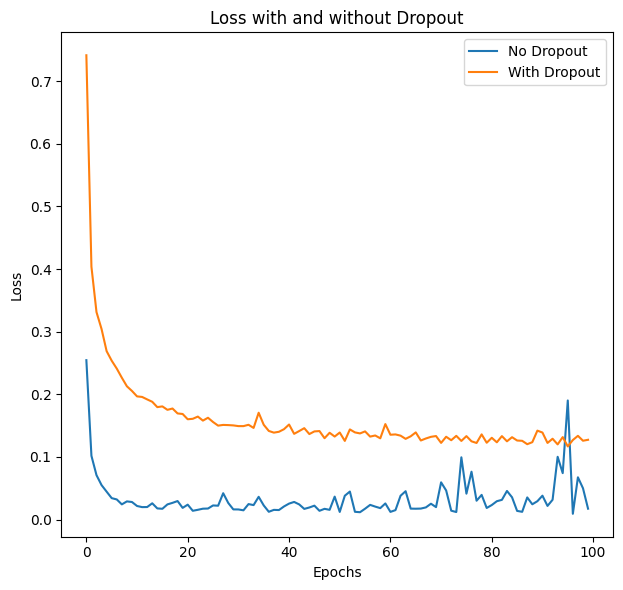

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


# # Стандартизация данных
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

# Создание нейронной сети без Dropout
model_no_dropout = keras.models.Sequential()
model_no_dropout.add(keras.layers.Dense(100, input_shape=x_train.shape[1:]))
model_no_dropout.add(keras.layers.Activation("relu"))
model_no_dropout.add(keras.layers.Dense(100))
model_no_dropout.add(keras.layers.Activation("relu"))
model_no_dropout.add(keras.layers.Dense(100))
model_no_dropout.add(keras.layers.Activation("softmax"))

model_no_dropout.compile(
    optimizer="adam", loss=losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
)

# Создание нейронной сети с Dropout
model_with_dropout = keras.models.Sequential()
model_with_dropout.add(keras.layers.Dense(100, input_shape=x_train.shape[1:]))
model_with_dropout.add(keras.layers.Activation("relu"))
#model_with_dropout.add(keras.layers.Dropout(0.8))
model_with_dropout.add(keras.layers.Dense(100))
model_with_dropout.add(keras.layers.Activation("relu"))
model_with_dropout.add(keras.layers.Dropout(0.8))
model_with_dropout.add(keras.layers.Dense(100))
model_with_dropout.add(keras.layers.Activation("softmax"))

model_with_dropout.compile(
    optimizer="adam", loss=losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
)

# Обучение нейронных сетей и запись истории лосса
history_no_dropout = model_no_dropout.fit(
    x_train, y_train, epochs=100, batch_size=32, verbose=0
)
history_with_dropout = model_with_dropout.fit(
    x_train, y_train, epochs=100, batch_size=32, verbose=0
)

test_loss, test_acc = model_no_dropout.evaluate(x_test, y_test)
print(f"Accuracy on the test set: {test_acc * 100:.2f}%")
test_loss, test_acc = model_with_dropout.evaluate(x_test, y_test)
print(f"Accuracy on the test set: {test_acc * 100:.2f}%")

# Визуализация графиков лосса
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_no_dropout.history["loss"], label="No Dropout")
plt.plot(history_with_dropout.history["loss"], label="With Dropout")
plt.title("Loss with and without Dropout")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 1s 2ms/step - loss: 15.9735 - accuracy: 0.9749
Accuracy on the test set: 97.49%
313/313 [==============================] - 1s 2ms/step - loss: 1.1308 - accuracy: 0.9657
Accuracy on the test set: 96.57%


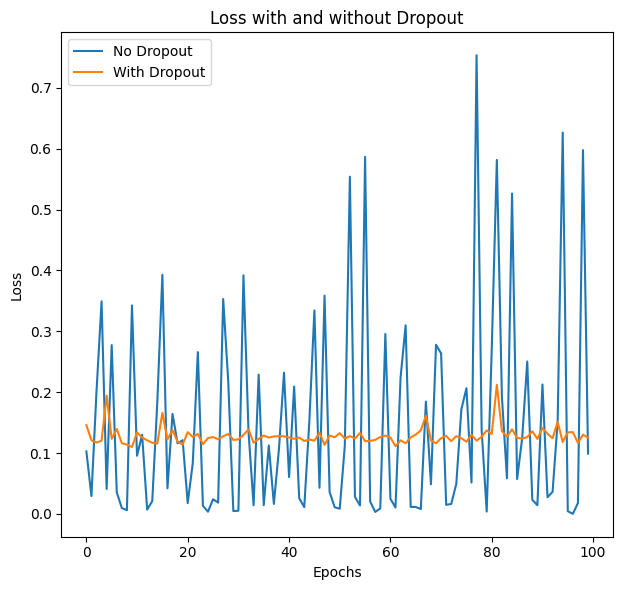

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


# # Стандартизация данных
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

# Создание нейронной сети без Dropout
model_no_batch = keras.models.Sequential()
model_no_batch.add(keras.layers.Dense(100, input_shape=x_train.shape[1:]))
model_no_batch.add(keras.layers.Activation("relu"))
model_no_batch.add(keras.layers.Dense(100))
model_no_batch.add(keras.layers.Activation("relu"))
model_no_batch.add(keras.layers.Dense(100))
model_no_batch.add(keras.layers.Activation("softmax"))

model_no_dropout.compile(
    optimizer="adam", loss=losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
)

# Создание нейронной сети с Dropout
model_with_batch = keras.models.Sequential()
model_with_batch.add(keras.layers.Dense(100, input_shape=x_train.shape[1:]))
model_with_batch.add(keras.layers.Activation("relu"))
model_with_batch.add(keras.layers.BatchNormalization())
model_with_batch.add(keras.layers.Dense(100))
model_with_batch.add(keras.layers.Activation("relu"))
model_with_batch.add(keras.layers.Dense(100))
model_with_batch.add(keras.layers.Activation("softmax"))

model_with_dropout.compile(
    optimizer="adam", loss=losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
)

# Обучение нейронных сетей и запись истории лосса
history_no_batch = model_no_dropout.fit(
    x_train, y_train, epochs=100, batch_size=32, verbose=0
)
history_with_batch = model_with_dropout.fit(
    x_train, y_train, epochs=100, batch_size=32, verbose=0
)

test_loss, test_acc = model_no_dropout.evaluate(x_test, y_test)
print(f"Accuracy on the test set: {test_acc * 100:.2f}%")
test_loss, test_acc = model_with_dropout.evaluate(x_test, y_test)
print(f"Accuracy on the test set: {test_acc * 100:.2f}%")

# Визуализация графиков лосса
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_no_batch.history["loss"], label="No Dropout")
plt.plot(history_with_batch.history["loss"], label="With Dropout")
plt.title("Loss with and without Dropout")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 1s 3ms/step - loss: 0.1222 - accuracy: 0.9708
Accuracy on the test set with stopping: 97.08%
313/313 [==============================] - 1s 3ms/step - loss: 2.9468 - accuracy: 0.9764
Accuracy on the test set without stopping: 97.64%


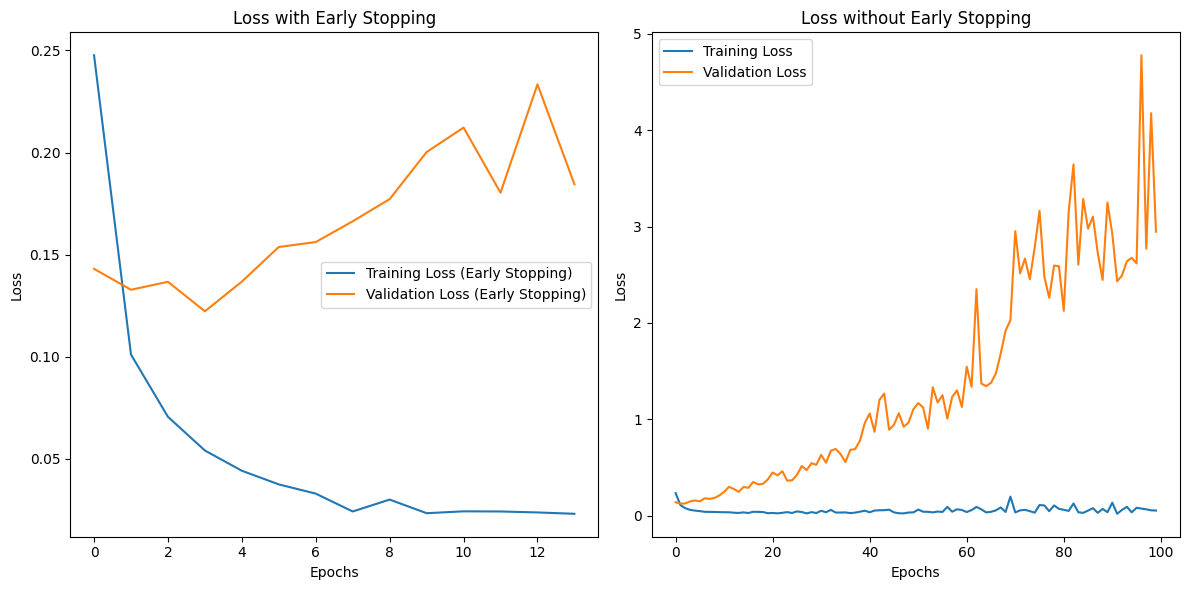

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# # Стандартизация данных
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


# Создание нейронной сети
def create_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(100, input_shape=x_train.shape[1:]))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.Activation("softmax"))
    model.compile(optimizer="adam", loss=losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model


# Создание callbacks для ранней остановки
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Создание двух одинаковых нейронных сетей с ранней остановкой
model1 = create_model()
history1 = model1.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[early_stopping],
)

model2 = create_model()
history2 = model2.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=16,
    verbose=0,
)

test_loss, test_acc = model1.evaluate(x_test, y_test)
print(f"Accuracy on the test set with stopping: {test_acc * 100:.2f}%")
test_loss, test_acc = model2.evaluate(x_test, y_test)
print(f"Accuracy on the test set without stopping: {test_acc * 100:.2f}%")

# Визуализация графиков лосса с ранней остановкой и без
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history["loss"], label="Training Loss (Early Stopping)")
plt.plot(history1.history["val_loss"], label="Validation Loss (Early Stopping)")
plt.title("Loss with Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history["loss"], label="Training Loss")
plt.plot(history2.history["val_loss"], label="Validation Loss")
plt.title("Loss without Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 1s 2ms/step


<Axes: >

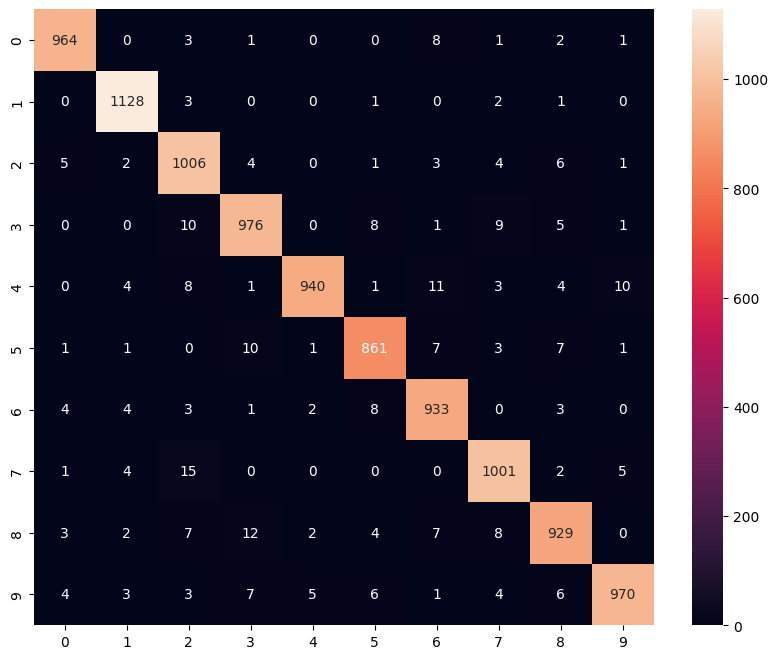

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_outputs = np.argmax(model1.predict(x_test), axis=1)

predicted_confusion_matrix = confusion_matrix(y_test, predicted_outputs)
predicted_confusion_matrix
plt.figure(figsize=(10, 8))
sns.heatmap(predicted_confusion_matrix, annot=True, fmt='g')


In [106]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator



inputs = keras.Input(shape=(784,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1]) 

# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy:", test_accuracy)



predicted_outputs = np.argmax(model.predict(x_test), axis=1)

predicted_confusion_matrix = confusion_matrix(y_test, predicted_outputs)
predicted_confusion_matrix

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Epoch 1/5
750/750 [==============================] - 3s 4ms/step - loss: 0.3058 - accuracy: 0.9097 - val_loss: 0.1545 - val_accuracy: 0.9554
Epoch 2/5
750/750 [==============================] - 3s 3ms/step - loss: 0.1252 - accuracy: 0.9626 - val_loss: 0.1332 - val_accuracy: 0.9610
Epoch 3/5
750/750 [==============================] - 3s 3ms/step - loss: 0.0839 - accuracy: 0.9745 - val_loss: 0.1286 - val_accuracy: 0.9632
Epoch 4/5
750/750 [==============================] - 3s 3ms/step - loss: 0.0641 - accuracy: 0.9800 - val_loss: 0.1254 - val_accuracy: 0.9658
Epoch 5/5
750/750 [==============================] - 3s 3ms/step - loss: 0.0488 - accuracy: 0.9848 - val_loss: 0.1290 - val_accuracy: 0.9657
313/313 - 1s - loss: 0.1307 - accuracy: 0.9680 - 634ms/epoch - 2ms/step
Test loss: 0.13068433105945587
Test accuracy: 0.9679999947547913
313/313 [==============================] - 1s 2ms/step - loss: 0.1307 - accuracy: 0.9680
Test accuracy: 0.9679999947547913
313/313 [==========================

array([[ 958,    1,    2,    0,    0,    8,    6,    1,    3,    1],
       [   0, 1122,    2,    4,    0,    2,    1,    2,    1,    1],
       [   4,    1,  994,   10,    1,    0,    6,    6,   10,    0],
       [   0,    0,    4,  973,    0,   14,    1,    4,    5,    9],
       [   1,    2,    6,    2,  938,    2,    8,    3,    4,   16],
       [   1,    1,    0,    7,    0,  873,    4,    0,    5,    1],
       [   3,    2,    0,    1,    3,   11,  933,    0,    5,    0],
       [   0,    5,   10,    4,    2,    1,    0,  997,    4,    5],
       [   0,    1,    3,   10,    2,   14,    4,    4,  934,    2],
       [   2,    4,    1,    5,    8,   13,    0,   11,    7,  958]])

In [109]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator



inputs1 = Input(shape=(28 * 28,))
inputs2 = Input(shape=(28 * 28,))
x = Dense(100, activation='relu')(inputs1)
x = Dense(100, activation='relu')(x)


y = Dense(32, activation='relu')(inputs1)
y = Dense(64, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(64, activation='relu')(y)
y = Dense(32, activation='relu')(y)

merged = Concatenate()([x, y])
x = Dense(128, activation='relu')(merged)
outputs = Dense(10, activation='softmax')(x)
#outputs = layers.Dense(10, activation='softmax')(x)
model = Model(inputs=inputs1, outputs=outputs)
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1]) 

# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy:", test_accuracy)



predicted_outputs = np.argmax(model.predict(x_test), axis=1)

predicted_confusion_matrix = confusion_matrix(y_test, predicted_outputs)
predicted_confusion_matrix

Epoch 1/5


2023-09-08 11:24:53.881152: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


750/750 [==============================] - 5s 5ms/step - loss: 0.2897 - accuracy: 0.9153 - val_loss: 0.1412 - val_accuracy: 0.9566
Epoch 2/5
750/750 [==============================] - 4s 5ms/step - loss: 0.1199 - accuracy: 0.9639 - val_loss: 0.1134 - val_accuracy: 0.9655
Epoch 3/5
750/750 [==============================] - 4s 5ms/step - loss: 0.0808 - accuracy: 0.9757 - val_loss: 0.0978 - val_accuracy: 0.9705
Epoch 4/5
750/750 [==============================] - 4s 5ms/step - loss: 0.0635 - accuracy: 0.9796 - val_loss: 0.0967 - val_accuracy: 0.9715
Epoch 5/5
750/750 [==============================] - 4s 5ms/step - loss: 0.0499 - accuracy: 0.9841 - val_loss: 0.0927 - val_accuracy: 0.9738
313/313 - 1s - loss: 0.0816 - accuracy: 0.9746 - 868ms/epoch - 3ms/step
Test loss: 0.08157996833324432
Test accuracy: 0.9746000170707703
313/313 [==============================] - 1s 3ms/step - loss: 0.0816 - accuracy: 0.9746
Test accuracy: 0.9746000170707703
313/313 [==============================] - 1s

array([[ 966,    1,    2,    2,    0,    0,    4,    1,    4,    0],
       [   0, 1122,    2,    2,    0,    1,    3,    1,    4,    0],
       [   5,    4, 1000,    3,    6,    0,    4,    5,    5,    0],
       [   0,    0,    6,  979,    0,   12,    0,    5,    8,    0],
       [   2,    0,    1,    0,  966,    0,    8,    0,    0,    5],
       [   2,    0,    0,   10,    1,  870,    4,    0,    4,    1],
       [   1,    3,    0,    1,    5,    6,  941,    0,    1,    0],
       [   0,    6,   13,    4,    0,    1,    0,  995,    4,    5],
       [   0,    0,    2,    6,    3,    5,    2,    5,  950,    1],
       [   2,    3,    1,    9,   19,    7,    0,    6,    5,  957]])

In [7]:
export_dir = 'model'
tf.saved_model.save(model,'model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [8]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

2023-09-08 11:25:57.292924: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-08 11:25:57.292967: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-08 11:25:57.293673: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: model
2023-09-08 11:25:57.295219: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-08 11:25:57.295233: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: model
2023-09-08 11:25:57.302057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-08 11:25:57.305672: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-08 11:25:57.382299: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: model
2023-09-08 11:25:57.408372: I tensorflow

In [9]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

615676

In [25]:
y_train.shape

(60000,)

In [11]:
!pip install pydot

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
